# ripe or rotten mango?

Se instalan e importan librerías para datos, preprocesamiento, visualización y modelos.

In [16]:
%reload_ext autoreload
%autoreload 2
# %pip install -q -r ../requirements.txt --user

from IPython.core.display import HTML
display(HTML("<style>td { white-space: nowrap; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import sys
sys.path.append('../')  

import pandas as pd 
from src.data import get_dataset, preprocess, graphic

### **Descripción del Problema**

El objetivo de este proyecto es clasificar imágenes de mangos en dos categorías: Ripe (maduro) y Rotten (podrido) utilizando técnicas de aprendizaje automático. El conjunto de datos utilizado proviene de [Kaggle](https://www.kaggle.com/datasets/adrinbd/unripe-ripe-rotten-mango) y contiene imágenes tomadas bajo diferentes condiciones de iluminación y fondos variados.

Este conjunto de datos consta de un total de 2,741 imágenes de mangos, que están etiquetadas en tres categorías: **Ripe**, **Unripe** (no maduro) y **Rotten**. Para esta implementación, nos enfocaremos exclusivamente en las 2,100 imágenes correspondientes a las categorías Ripe y Rotten, las cuales se dividen de la siguiente manera:

- **1,989 imágenes** para el conjunto de entrenamiento.
- **211 imágenes** para el conjunto de validación.

Cabe destacar que el conjunto de datos solo incluye las etiquetas de clase (Ripe o Rotten) asociadas a cada imagen, por lo que será necesario extraer características adicionales a partir de las imágenes mismas para poder entrenar el modelo de manera efectiva.

Se utilizará la clase `get_dataset` para descargar y cargar los conjuntos de entrenamiento y validación, generando archivos `.csv` que contienen los nombres y etiquetas de las imágenes, lo que facilitará su manejo para el preprocesamiento y entrenamiento del modelo.

Loaded 'raw\train' in 0.02s | 1989 rows, 2 cols
Loaded 'raw\validation' in 0.01s | 211 rows, 2 cols


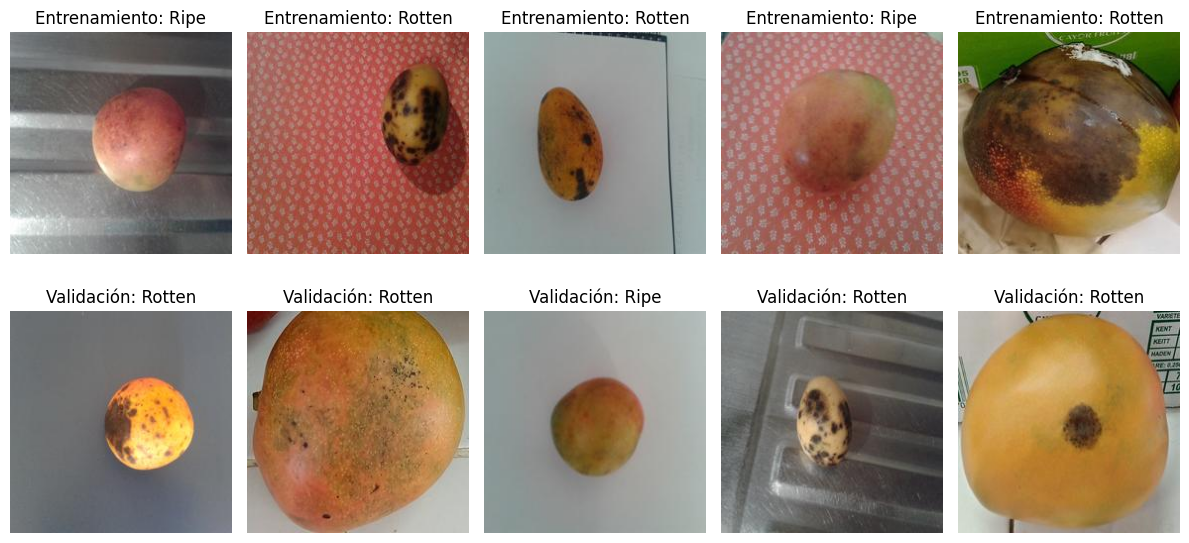

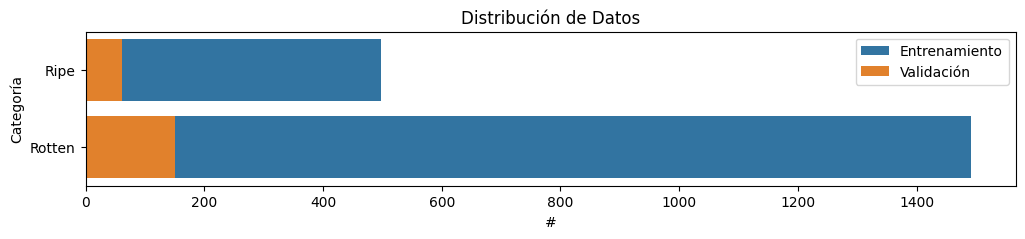

In [17]:
dataset = get_dataset()
graphic.show_dataset(dataset.train_data, dataset.validation_data)
graphic.show_data_distribution(dataset.train_data, dataset.validation_data)

### **Preprocesamiento**

Para preparar las imágenes de mangos para una clasificación efectiva, se implementaron diversas estrategias, considerando las características y necesidades del conjunto de datos:

#### Conversión de Variables

El conjunto de datos incluye imágenes de mangos clasificadas en dos categorías. Se realizó una codificación binaria de las etiquetas, asignando el valor **0** a Ripe y **1** a Rotten, lo cual es necesario para trabajar con modelos de clasificación.

In [18]:
labels = dataset.get_labels()
print(f"Labels: {set(labels['train'])}")

Labels: {np.int64(0), np.int64(1)}


#### Selección y Reducción de Características

Se extrajeron diversas características relevantes de las imágenes:

- Estadísticas de los canales RGB (media y desviación estándar).
- Histogramas de intensidad en los canales RGB.
- Características de textura de Haralick (entropía, homogeneidad, contraste, correlación).

Para garantizar que las diferencias en la escala de las características no afectaran negativamente el rendimiento del modelo, se aplicó un **MinMaxScaler**, escalando todas las características al rango [0, 1]. Esto favoreció la convergencia y el desempeño de los algoritmos de aprendizaje automático.

In [19]:
preprocessor = preprocess(dataset)
train_data = pd.DataFrame(preprocessor.train_data)
validation_data = pd.DataFrame(preprocessor.validation_data)
train_data.describe()

Loaded 'processed\train' in 6.12s | 1989 rows, 778 cols
Loaded 'processed\validation' in 0.36s | 211 rows, 778 cols


,mean_r,mean_g,mean_b,std_dev_r,std_dev_g,std_dev_b,hist_0,hist_1,hist_2,hist_3,...,hist_762,hist_763,hist_764,hist_765,hist_766,hist_767,texture_contrast,texture_correlation,texture_energy,texture_homogeneity
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,...,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,0.446132,0.344431,0.354143,0.390322,0.291441,0.329092,0.005064,0.007870,0.008349,0.010582,...,0.028082,0.003139,0.003909,0.004746,0.005924,0.021726,0.069757,0.861402,0.083771,0.491656
std,0.157576,0.143841,0.153833,0.177011,0.151412,0.170014,0.029179,0.037776,0.040730,0.044865,...,0.087092,0.028906,0.024761,0.032238,0.033447,0.110285,0.075534,0.161573,0.113562,0.265662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.342427,0.246236,0.252062,0.273051,0.179727,0.198023,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020179,0.817522,0.022223,0.285310
50%,0.448688,0.318214,0.323236,0.385831,0.271099,0.324202,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053437,0.923070,0.036477,0.434306
75%,0.549893,0.438036,0.459183,0.502856,0.387281,0.433245,0.000000,0.000000,0.000504,0.000495,...,0.004947,0.000369,0.000368,0.000428,0.000082,0.000323,0.093573,0.968414,0.119930,0.765083
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Reducción de Dimensionalidad con PCA

Para reducir la dimensionalidad y evitar el sobreajuste, se utilizó **Análisis de Componentes Principales**, manteniendo **95% de varianza** en el conjunto de entrenamiento. Este paso ayudó a eliminar redundancias y a preservar la mayor cantidad posible de información relevante.

In [20]:
preprocessor.apply_pca(n_components=0.95)
train_pca = pd.DataFrame(preprocessor.train_pca)
validation_pca = pd.DataFrame(preprocessor.validation_pca)
train_pca.describe()

PCA components: 86


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
count,1.989000e+03,1.989000e+03,1989.000000,1.989000e+03,1989.000000,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,...,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03,1.989000e+03
mean,-3.572362e-17,-1.428945e-17,0.000000,-3.572362e-17,0.000000,-7.144723e-18,2.143417e-17,-1.875490e-17,1.786181e-17,8.930904e-18,...,1.596399e-17,-5.135270e-18,1.384290e-17,1.116363e-18,1.161018e-17,2.366690e-17,-5.693451e-18,-9.349540e-18,2.902544e-18,-4.465452e-18
std,1.166260e+00,1.034568e+00,0.848130,7.759170e-01,0.680932,5.681931e-01,5.163888e-01,4.686866e-01,4.277407e-01,4.134202e-01,...,8.520634e-02,8.427532e-02,8.358817e-02,8.294036e-02,8.119783e-02,8.099004e-02,8.057328e-02,7.920159e-02,7.860996e-02,7.750198e-02
min,-2.607793e+00,-2.629408e+00,-2.046576,-2.213567e+00,-3.173307,-2.096863e+00,-1.884857e+00,-1.873200e+00,-1.936301e+00,-1.465704e+00,...,-4.952147e-01,-9.431862e-01,-7.790937e-01,-5.149739e-01,-3.833461e-01,-4.052277e-01,-5.879065e-01,-3.697691e-01,-3.776711e-01,-4.712832e-01
25%,-5.451725e-01,-7.356239e-01,-0.569507,-3.397343e-01,-0.401653,-2.839983e-01,-2.107120e-01,-2.458486e-01,-2.331285e-01,-2.258335e-01,...,-3.881367e-02,-3.548452e-02,-4.484114e-02,-3.443655e-02,-4.535113e-02,-4.635042e-02,-3.374185e-02,-3.561060e-02,-3.751458e-02,-3.333989e-02
50%,-1.232276e-01,3.338507e-01,-0.074228,8.103757e-02,-0.045612,-3.895632e-02,-1.011398e-02,5.065509e-03,-2.611116e-02,-2.125084e-02,...,1.263298e-03,-3.924493e-04,-3.878306e-03,-3.366552e-03,-1.400808e-03,-4.321262e-03,6.546125e-04,1.355332e-03,-2.615755e-03,-2.510054e-03
75%,2.164254e-01,7.801271e-01,0.575656,4.186674e-01,0.324997,2.487062e-01,2.102333e-01,2.582376e-01,2.008991e-01,1.992605e-01,...,4.098621e-02,4.097408e-02,4.091995e-02,3.444427e-02,4.370435e-02,4.419246e-02,3.051308e-02,3.611054e-02,3.641719e-02,3.195712e-02
max,3.157889e+00,2.204431e+00,3.098797,3.059541e+00,2.266834,2.368505e+00,3.512741e+00,2.096209e+00,3.171087e+00,1.719458e+00,...,5.320674e-01,4.479684e-01,4.838426e-01,8.291061e-01,4.069765e-01,4.662503e-01,6.009892e-01,3.760088e-01,3.666062e-01,4.683470e-01


#### Balanceo del Dataset

Dado que el conjunto original estaba desbalanceado (con más muestras de Rotten), se aplicarán **class weights** durante el entrenamiento. Esto asigna un mayor peso a la clase minoritaria (Ripe), ayudando al modelo a enfocarse de manera más equilibrada en ambas clases.

In [21]:
class_weight = dataset.get_weights()
print(f"Class weights: Ripe {class_weight[0]:.2f}, Rotten {class_weight[1]:.2f}")

Class weights: Ripe 2.00, Rotten 0.67


#### Vectorización de los Datos

Las características extraídas fueron organizadas en formato **CSV**, con cada fila representando una imagen y cada columna conteniendo los valores de las características correspondientes. Este formato facilitó la conversión de los datos para su procesamiento y análisis con modelos de machine learning.

Estas estrategias de preprocesamiento permiten optimizar los datos para la construcción de modelos de clasificación, mejorando tanto la eficiencia computacional como el rendimiento general del modelo.

### **Visualización**

Para explorar las características del conjunto de datos, se utilizaron diversas herramientas de visualización:

#### Muestras Aleatorias y sus Histogramas RGB

Se mostraron tres imágenes aleatorias del conjunto de entrenamiento junto con sus histogramas de los canales RGB, lo que permitió observar cómo se distribuyen las intensidades de color en cada imagen.

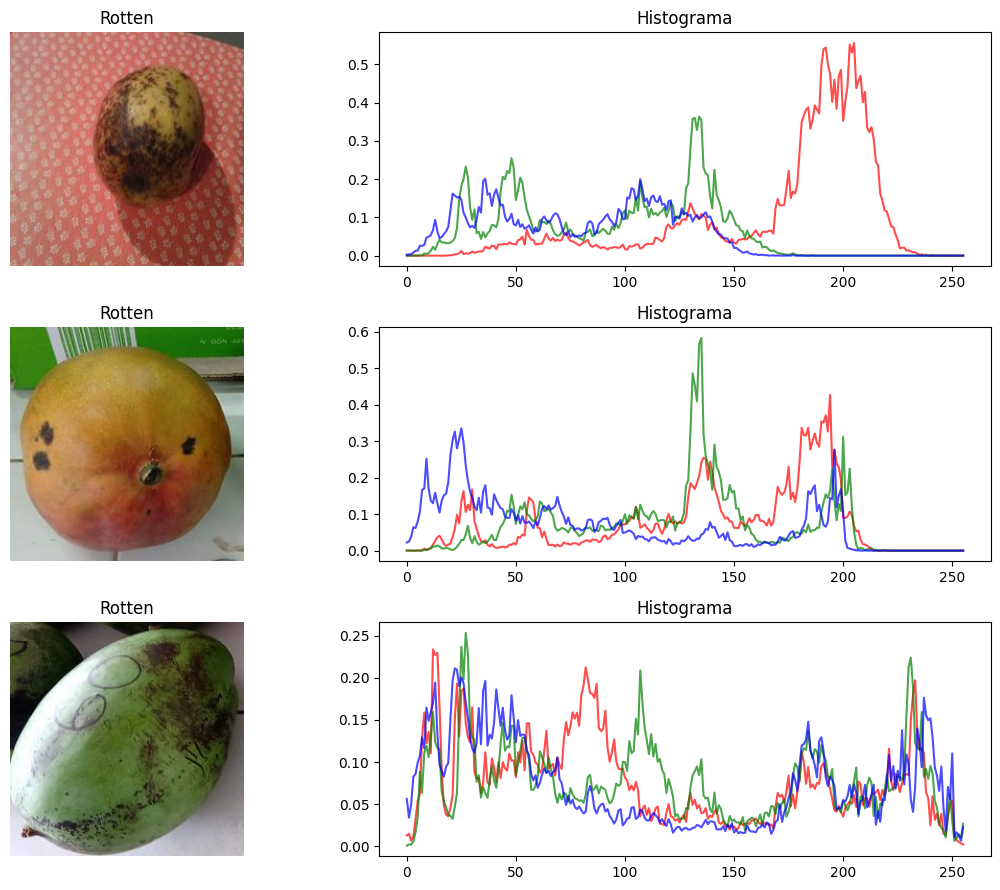

In [22]:
images = pd.DataFrame(dataset.train_data)
graphic.show_samples(images, train_data, num_samples=3)

#### Distribución de Estadísticas RGB  

Se analizaron las distribuciones de la media y desviación estándar de los canales RGB mediante histogramas, lo que reveló cómo varían estas características en el conjunto de datos.

#### Matriz de Correlación  

Se mostró una matriz de correlación para entender las relaciones entre las características de los canales RGB, lo que ayudó a identificar posibles redundancias.

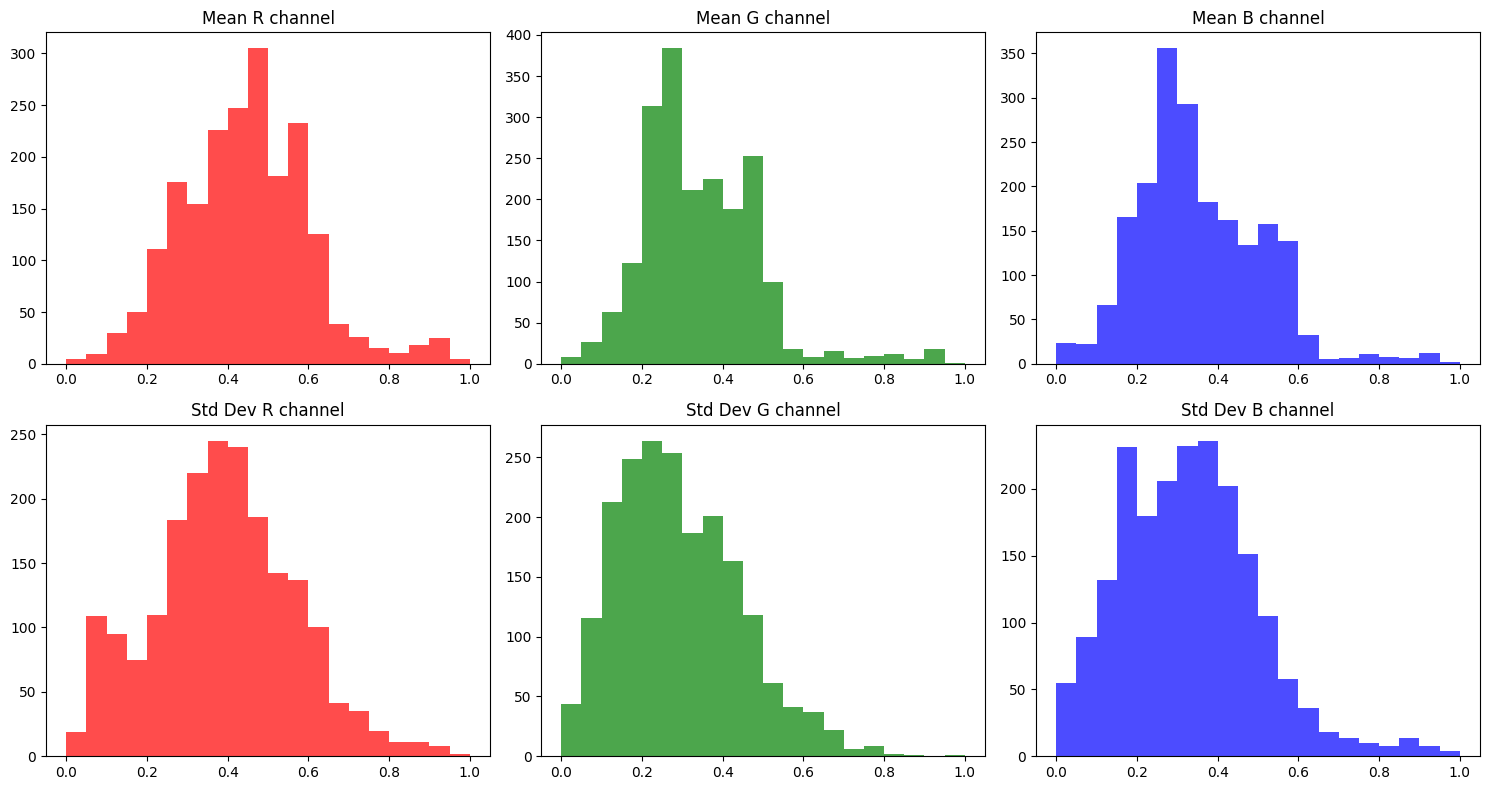

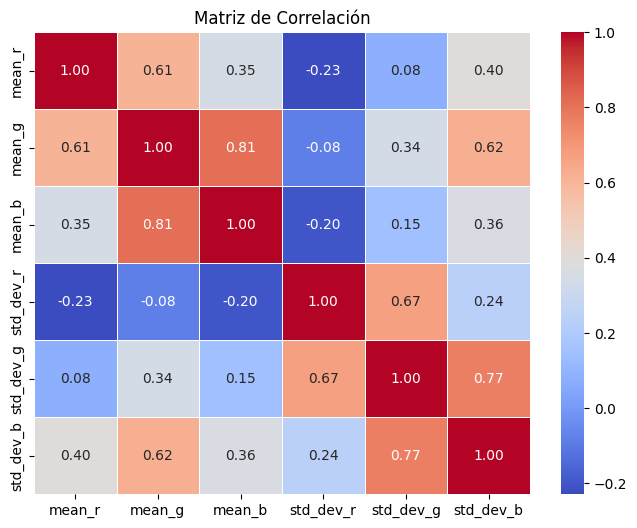

In [23]:
stats_key = ["mean_r", "mean_g", "mean_b", "std_dev_r", "std_dev_g", "std_dev_b"]
stats = train_data[stats_key]

graphic.show_channels(stats)
graphic.show_correlation(stats)

#### Diagrama de dispersión de PCA

Se aplicó PCA para reducir la dimensionalidad y se visualizó la separación de las clases Ripe y Rotten en el espacio reducido, evaluando la efectividad de la reducción de características.

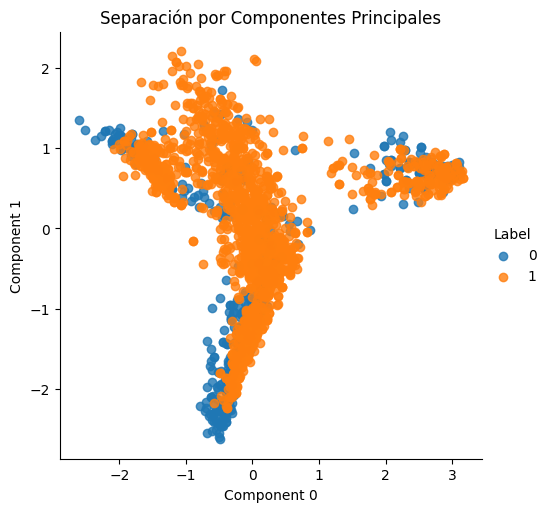

In [24]:
graphic.show_pca(train_pca, labels["train"])

Estas visualizaciones proporcionan una visión clara de la estructura de los datos, lo que ayuda a identificar patrones, correlaciones y posibles problemas antes de entrenar el modelo.

### **Modelos de predicción**

En este análisis, se entrenarán y evaluarán varios modelos de predicción para abordar un problema de clasificación. El objetivo es comparar el rendimiento de cada modelo bajo diferentes configuraciones de características, tanto con las características originales extraídas de los datos como con las características transformadas mediante PCA (Análisis de Componentes Principales). Esto permitirá explorar cómo la reducción dimensional impacta en el desempeño de los modelos.

El primer paso será dividir el conjunto de datos en dos subconjuntos: uno para entrenamiento y otro para validación. Esta división es fundamental para entrenar los modelos en un conjunto de datos y evaluar su capacidad de generalización en un conjunto independiente. 

La evaluación se realizará en tres etapas:

1. **Con PCA**: Se entrenarán y evaluarán los modelos con las características transformadas por PCA.
2. **Con características extraídas**: Se evaluarán los mismos modelos utilizando las características originales sin reducción dimensional.
3. **Optimización con GridSearchCV**: Se seleccionará el mejor modelo de los dos enfoques anteriores y se optimizarán sus hiperparámetros utilizando `GridSearchCV`.

Esto permitirá comparar el rendimiento de los modelos con y sin reducción dimensional, y encontrar el modelo más adecuado mediante optimización de hiperparámetros.

In [25]:
from src.model import mango_reg, mango_tree, mango_forest, mango_net, mango_dnn

X_features = {"train": train_data, "validation": validation_data}
X_pca = {"train": train_pca, "validation": validation_pca}

#### Regresión Multivariante
Un modelo lineal simple que asume una relación directa entre las variables independientes y la dependiente.

In [29]:
regression = mango_reg(X_features, labels)
regression.run()

Model initialized successfully.
Model trained successfully with best alpha: 1.67
R^2 Score: 0.5227
Root Mean Squared Error (RMSE): 0.3035

Validation Results:
R^2 Score: 0.5929
Root Mean Squared Error (RMSE): 0.2893


#### Arboles de Decisión

Captura relaciones no lineales y es interpretable.

In [26]:
decision_tree = mango_tree(X_features, labels)
decision_tree.run()

Model initialized successfully.
Model trained successfully.
Accuracy: 0.9194


,precision,recall,f1-score,support,0,1
0,0.892857,0.819672,0.854701,61.000000,50.0,11.0
1,0.929032,0.960000,0.944262,150.000000,6.0,144.0
accuracy,0.919431,0.919431,0.919431,0.919431,,
macro avg,0.910945,0.889836,0.899482,211.000000,,
weighted avg,0.918574,0.919431,0.918370,211.000000,,


#### Random Forest

Un conjunto de árboles de decisión que mejora la precisión y reduce el sobreajuste.

#### Red neuronal

Captura relaciones complejas y no lineales, con un enfoque en optimizar su rendimiento.

In [27]:
neural_network = mango_net(X_features, labels)
neural_network.run()

Model initialized successfully.
Model trained successfully.
Accuracy: 0.9526


,precision,recall,f1-score,support,0,1
0,0.880597,0.967213,0.921875,61.000000,59.0,2.0
1,0.986111,0.946667,0.965986,150.000000,8.0,142.0
accuracy,0.952607,0.952607,0.952607,0.952607,,
macro avg,0.933354,0.956940,0.943931,211.000000,,
weighted avg,0.955607,0.952607,0.953234,211.000000,,


#### Red neuronal profunda

Captura relaciones complejas y no lineales, con un enfoque en optimizar su rendimiento.

In [28]:
deep_neural_network = mango_dnn(X_features, labels, class_weight=class_weight)
deep_neural_network.run()

Model initialized successfully.
Model trained successfully.
7/7 [==============================] - 0s 2ms/step
Accuracy: 0.9810


,precision,recall,f1-score,support,0,1
0,0.938462,1.000000,0.968254,61.000000,61.0,0.0
1,1.000000,0.973333,0.986486,150.000000,4.0,146.0
accuracy,0.981043,0.981043,0.981043,0.981043,,
macro avg,0.969231,0.986667,0.977370,211.000000,,
weighted avg,0.982209,0.981043,0.981215,211.000000,,
